In [268]:
import torch
from torch.nn import Module, Parameter, ModuleList
from torch.optim import Adam, RMSprop, Adamax
from torch import optim
import torch.distributions as distributions
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Models

In [442]:
class Normal(Module):
    def __init__(self, loc, scale):
        super(Normal, self).__init__()
        self.loc = Parameter(torch.tensor(loc))
        self.log_scale = Parameter(torch.tensor(scale).log())
        
    def log_prob(self, value):
        model = distributions.MultivariateNormal(self.loc, self.scale)
        return model.log_prob(value)
    
    def sample(self, batch_size):
        model = distributions.MultivariateNormal(self.loc, self.scale)
        return model.rsample((batch_size,))
    
    @property
    def scale(self):
        return self.log_scale.exp()
    
    
class Mixture(Module):
    def __init__(self, models, weights):
        super(Mixture, self).__init__()
        self.categorical = distributions.Categorical(probs=torch.tensor(weights))
        self.models = ModuleList(models)
        
    def log_prob(self, value):
        log_probs = torch.stack([sub_model.log_prob(value)
                                 for sub_model in self.models])
        return torch.logsumexp(log_probs + self.categorical.probs.unsqueeze(1).log(), dim=0)

    def sample(self, batch_size):
        indices = self.categorical.sample((batch_size,))
        samples = torch.stack([sub_model.sample(batch_size)
                               for sub_model in self.models])
        return samples[indices, np.arange(batch_size)]

# KL Divergences

In [443]:
def forward_kl(p_model, q_model, batch_size=64):
    p_samples = p_model.sample(batch_size)
    return (p_model.log_prob(p_samples)-q_model.log_prob(p_samples)).sum()

def reverse_kl(p_model, q_model, batch_size=64):
    q_samples = q_model.sample(batch_size)
    return -(p_model.log_prob(q_samples) - q_model.log_prob(q_samples)).sum()

def js_divergence(p_model, q_model, batch_size=64):
    M = Mixture([p_model, q_model], [0.5, 0.5])
    return 0.5 * (forward_kl(p_model, M) + forward_kl(q_model, M))

# Training Functions

In [444]:
class Statistics:
    
    def __init__(self):
        self.data = {}
    
    def update(self, **kwargs):
        for k,v in kwargs.items():
            if k not in self.data:
                self.data[k] = []
            self.data[k].append(v)

def plot_stats(stats, goals=None):
    palette = plt.get_cmap('Set1')
    fig, axes = plt.subplots(1, len(stats.data.keys()), figsize=(12, 6))
    for index, value in enumerate(stats.data.keys()):
        axes[index].set_title(f"{value} curve")
        axes[index].set_xlabel('Epoch')
        axes[index].set_ylabel(value)
        axes[index].plot(np.arange(0.0, len(stats.data[value]), 1.0),
                         stats.data[value], color="#955196")
    if goals is not None:
        axes[1].axhline(goals[0], color="#ff6e54", linewidth=4)
        axes[2].axhline(goals[1], color="#ff6e54", linewidth=4)
    plt.tight_layout()
    plt.show()
    
def plot_models(p_model, q_model):
    q_samples = q_model.sample(10000).detach().numpy()
    p_samples = p_model.sample(10000).detach().numpy()
    ax = sns.distplot(q_samples, color = '#003f5c', label="Learned Model")
    ax = sns.distplot(p_samples, color = '#ffa600', label="True Model")
    plt.xlabel("Sample")
    plt.ylabel("Density")
    plt.title("Distplot for Models")
    plt.legend()
    plt.show()

def update_stats(stats, q_model, loss):
    if isinstance(q_model, Normal):
        stats.update(loss=loss.item(), 
                     loc=q_model.loc.item(), 
                     scale=q_model.scale.item())
    elif isinstance(q_model, Mixture):
        stats.update(loss=loss.item(), 
                     loc_1=q_model.models[0].loc.item(), 
                     scale_1=q_model.models[0].scale.item(),
                     loc_2=q_model.models[1].loc.item(), 
                     scale_2=q_model.models[1].scale.item())
        

In [445]:
def train(p_model, q_model, method, epochs=1000, batch_size=64, 
          lr=0.01, optimizer='Adam', collect_stats=True):
    optimizer = getattr(optim, optimizer)(q_model.parameters(), lr=lr)
    stats = Statistics()
    
    for i in range(epochs):
        optimizer.zero_grad()
        loss = method(p_model, q_model, batch_size)
        loss.backward()
        optimizer.step()
        update_stats(stats, q_model, loss)
        
    return stats

# Example 1: Fitting Normals

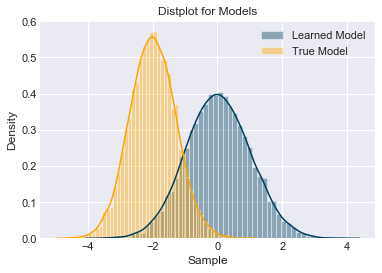

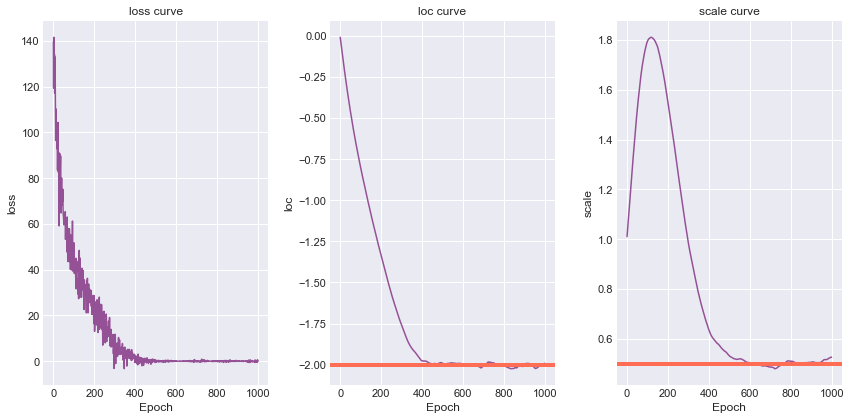

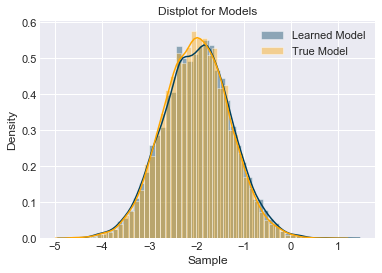

In [446]:
# Train Forward
p_model = Normal([-2.0], [[0.5]])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, forward_kl)
plot_stats(stats, [p_model.loc.item(), p_model.scale.item()])
plot_models(p_model, q_model)

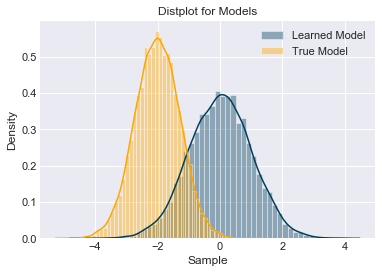

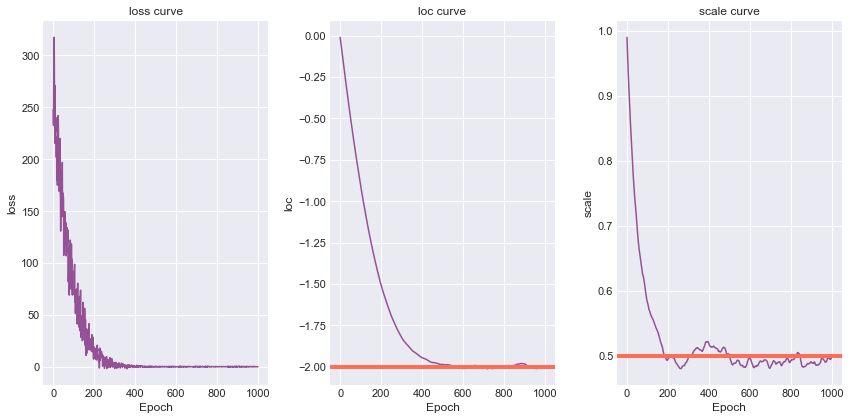

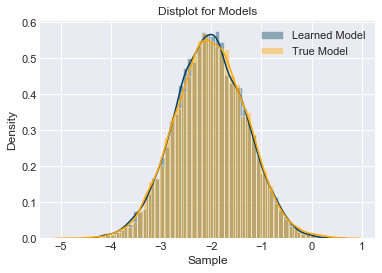

In [447]:
# Train Reverse
p_model = Normal([-2.0], [[0.5]])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, reverse_kl)
plot_stats(stats, [p_model.loc.item(), p_model.scale.item()])
plot_models(p_model, q_model)

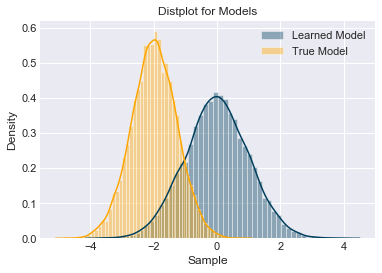

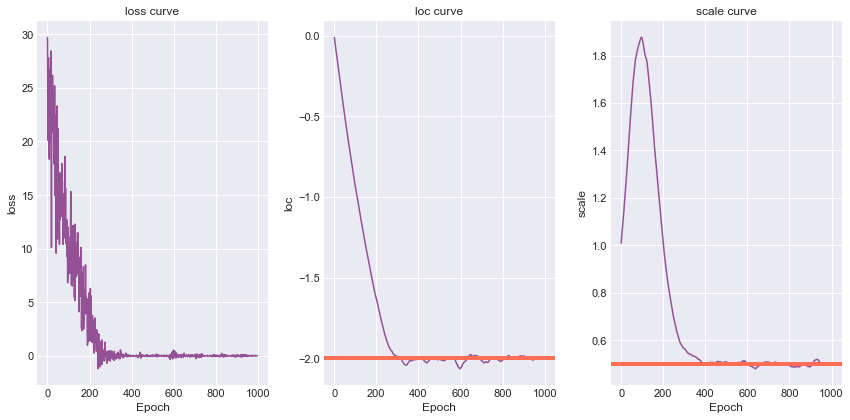

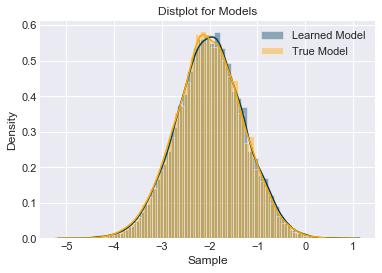

In [448]:
# Train Reverse
p_model = Normal([-2.0], [[0.5]])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, js_divergence)
plot_stats(stats, [p_model.loc.item(), p_model.scale.item()])
plot_models(p_model, q_model)

# Example 2: Bimodel Normal

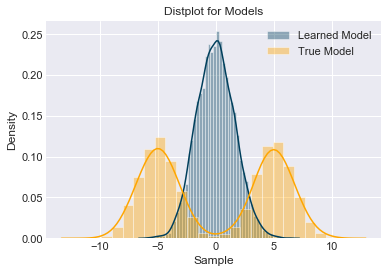

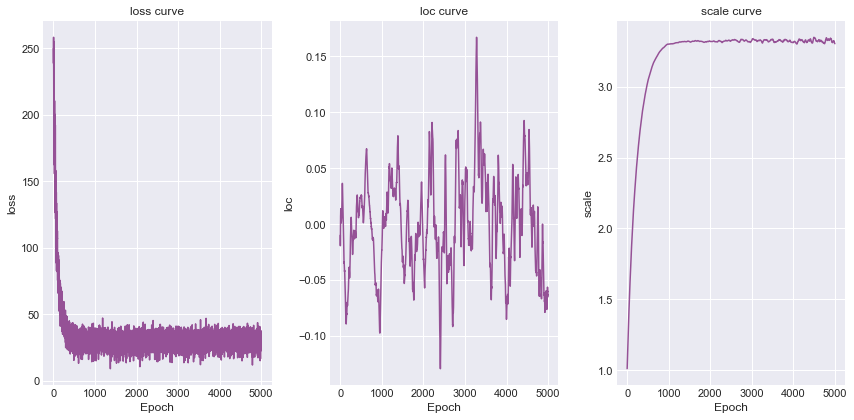

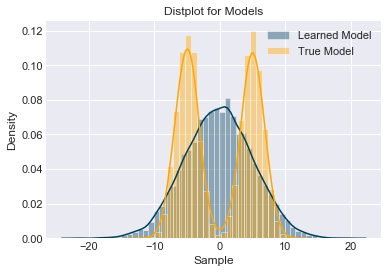

In [379]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, forward_kl, epochs=5000)
plot_stats(stats)
plot_models(p_model, q_model)

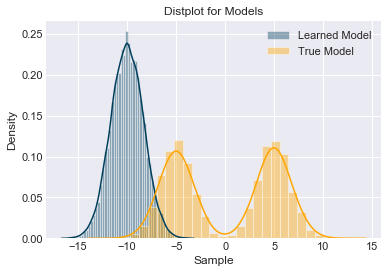

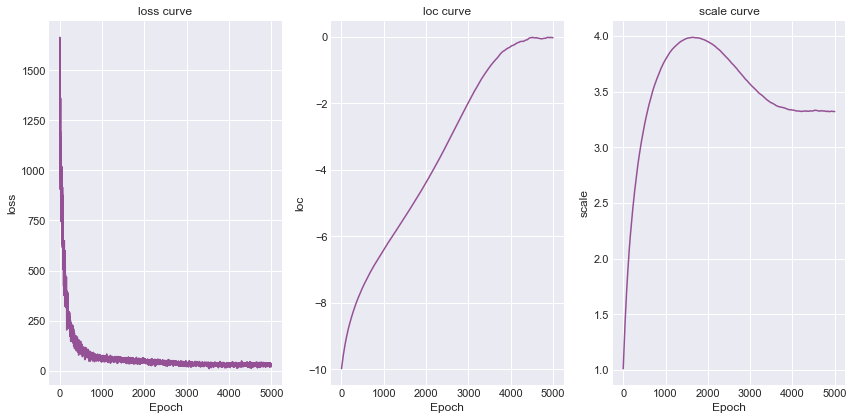

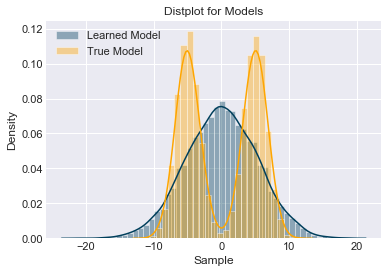

In [380]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([-10.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, forward_kl, epochs=5000)
plot_stats(stats)
plot_models(p_model, q_model)

### Reverse KL 3 Times

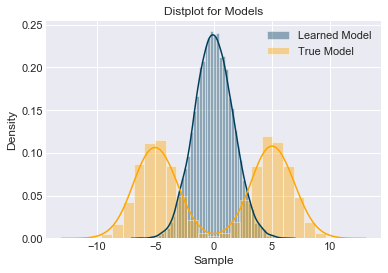

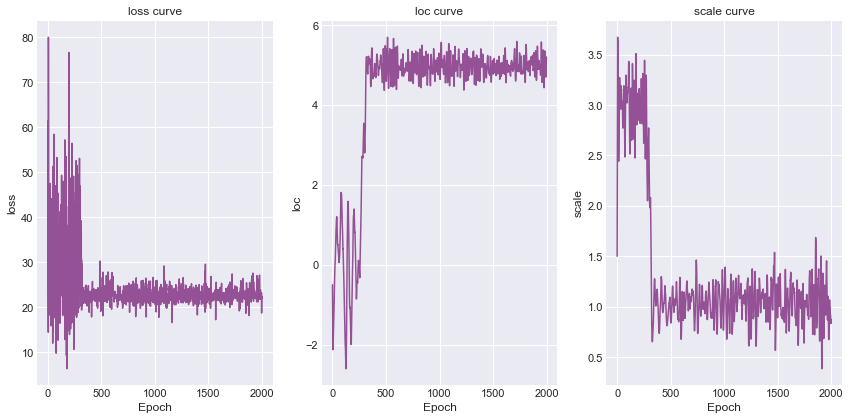

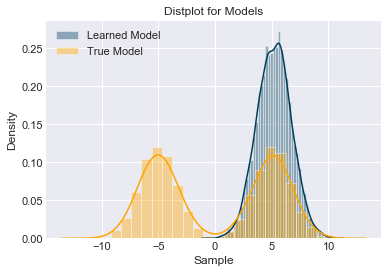

In [402]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, reverse_kl, batch_size=32,
              epochs=2000, lr=0.5, optimizer='Adam')
plot_stats(stats)
plot_models(p_model, q_model)

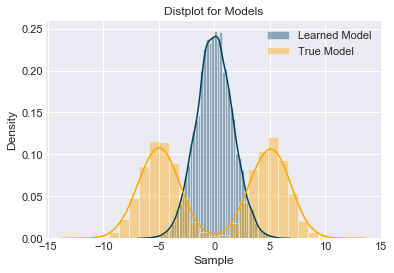

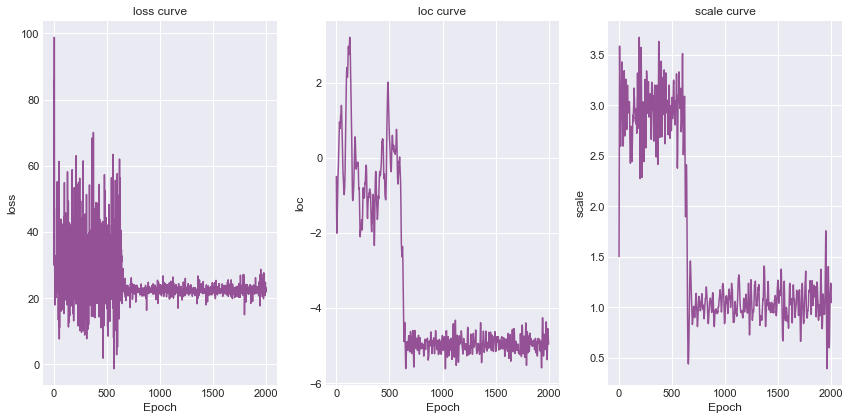

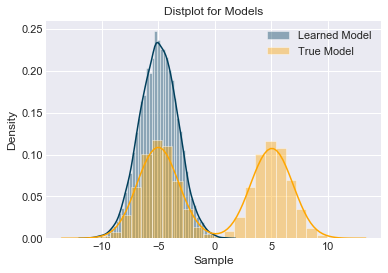

In [398]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, reverse_kl, batch_size=32,
              epochs=2000, lr=0.5, optimizer='Adam')
plot_stats(stats)
plot_models(p_model, q_model)

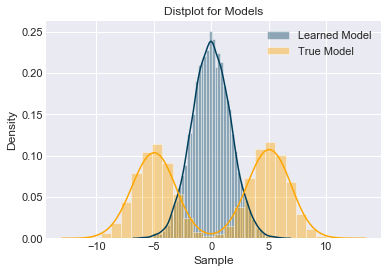

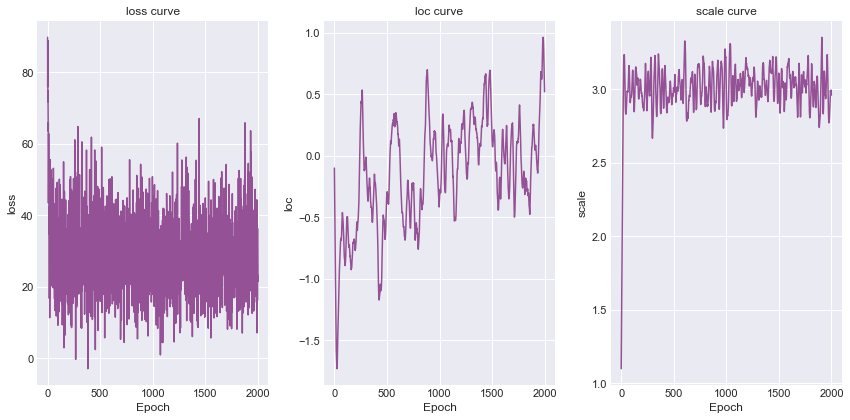

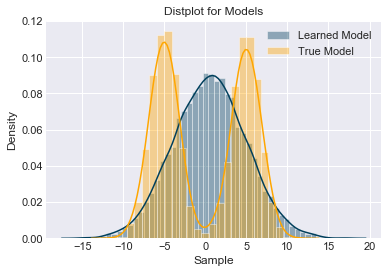

In [408]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, reverse_kl, batch_size=32,
              epochs=2000, lr=0.1, optimizer='Adam')
plot_stats(stats)
plot_models(p_model, q_model)

### JS Divergence with Bimodal and Normal

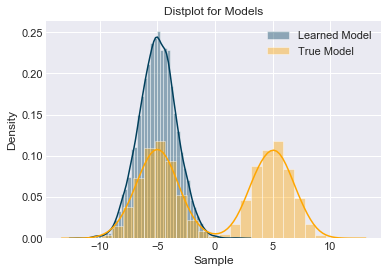

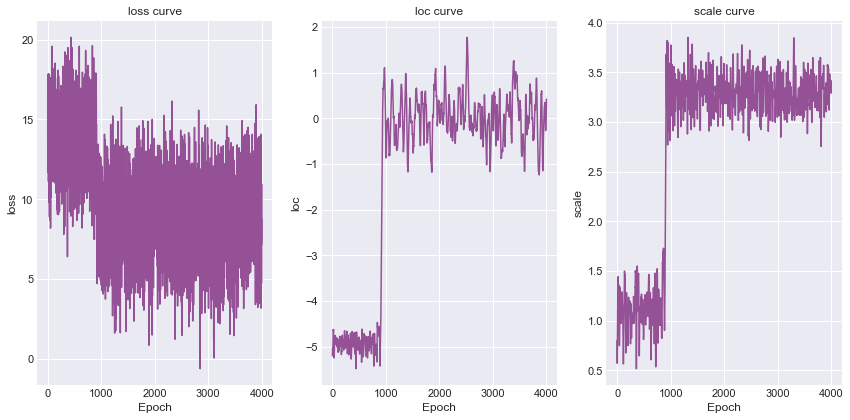

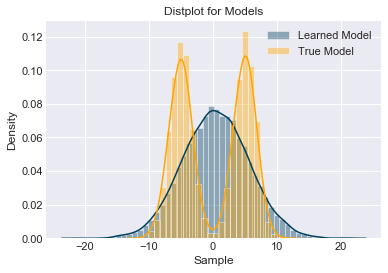

In [432]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([-5.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, js_divergence,
              epochs=4000, lr=0.2, optimizer='Adam')
plot_stats(stats)
plot_models(p_model, q_model)

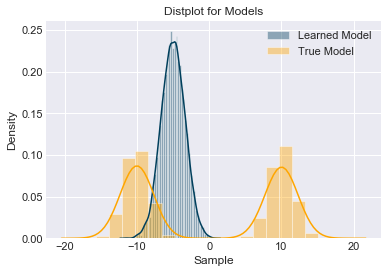

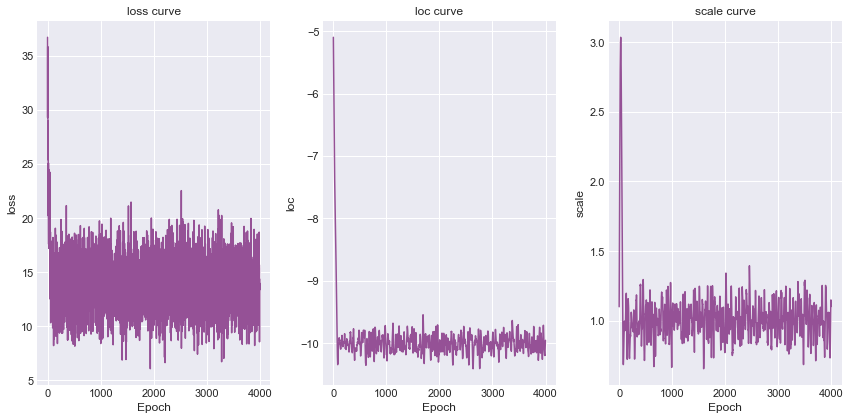

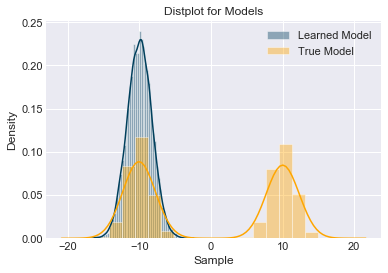

In [435]:
p_model = Mixture([Normal([-10.0], [[1.0]]), Normal([10.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([-10.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, js_divergence,
              epochs=4000, lr=0.1, optimizer='Adam')
plot_stats(stats)
plot_models(p_model, q_model)

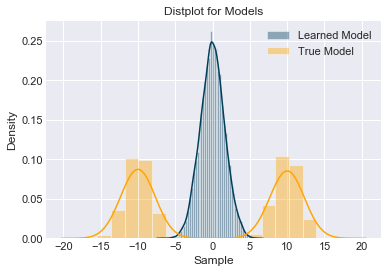

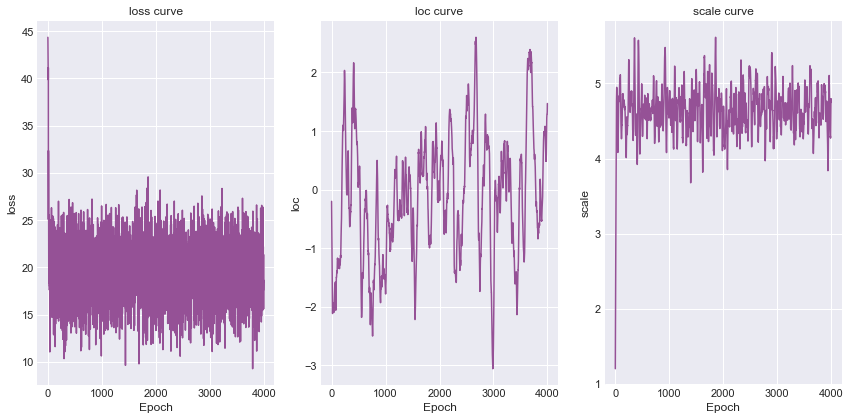

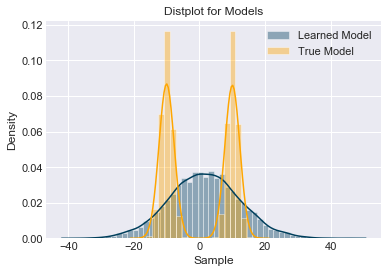

In [434]:
p_model = Mixture([Normal([-10.0], [[1.0]]), Normal([10.0], [[1.0]])], [0.5, 0.5])
q_model = Normal([0.0], [[1.0]])

plot_models(p_model, q_model)
stats = train(p_model, q_model, js_divergence,
              epochs=4000, lr=0.2, optimizer='Adam')
plot_stats(stats)
plot_models(p_model, q_model)

# Bimodal to Bimodal

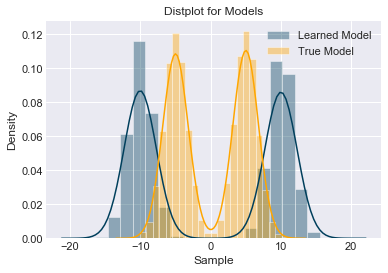

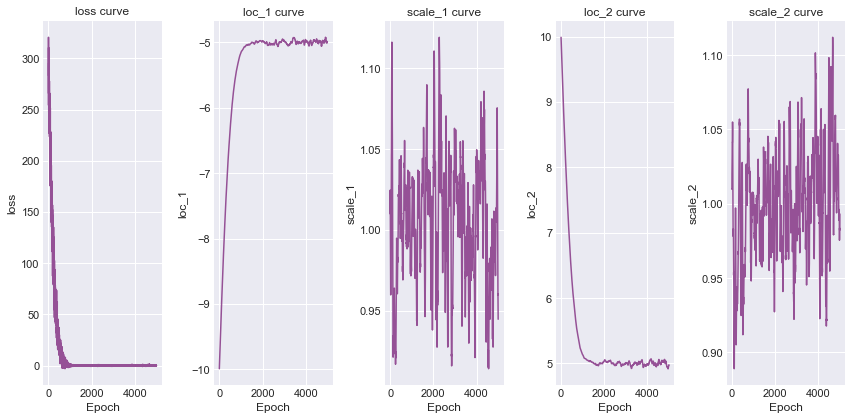

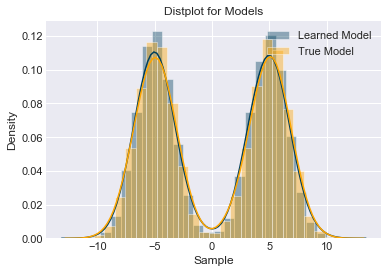

In [436]:
p_model = Mixture([Normal([-5.0], [[1.0]]), Normal([5.0], [[1.0]])], [0.5, 0.5])
q_model = Mixture([Normal([-10.0], [[1.0]]), Normal([10.0], [[1.0]])], [0.5, 0.5])

plot_models(p_model, q_model)
stats = train(p_model, q_model, reverse_kl, epochs=5000)
plot_stats(stats)
plot_models(p_model, q_model)

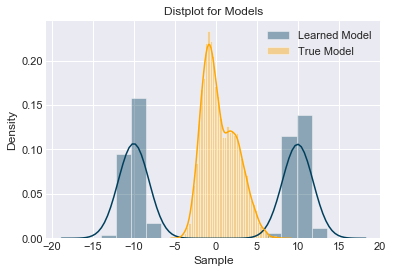

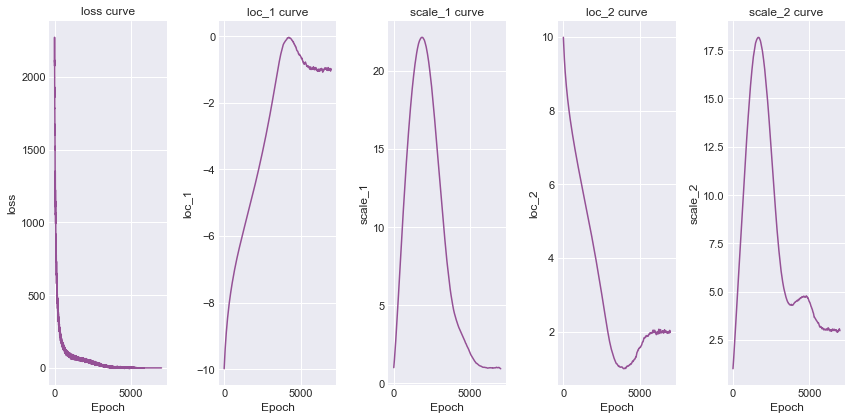

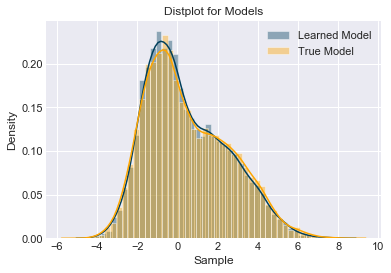

In [461]:
p_model = Mixture([Normal([-1.0], [[1.0]]), Normal([2.0], [[3.0]])], [0.5, 0.5])
q_model = Mixture([Normal([-10.0], [[1.0]]), Normal([10.0], [[1.0]])], [0.5, 0.5])

plot_models(p_model, q_model)
stats = train(p_model, q_model, forward_kl, epochs=7000)
plot_stats(stats)
plot_models(p_model, q_model)

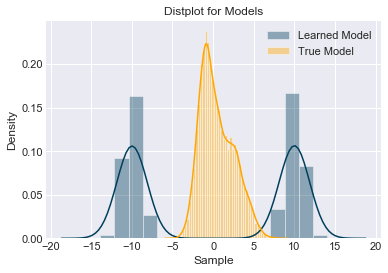

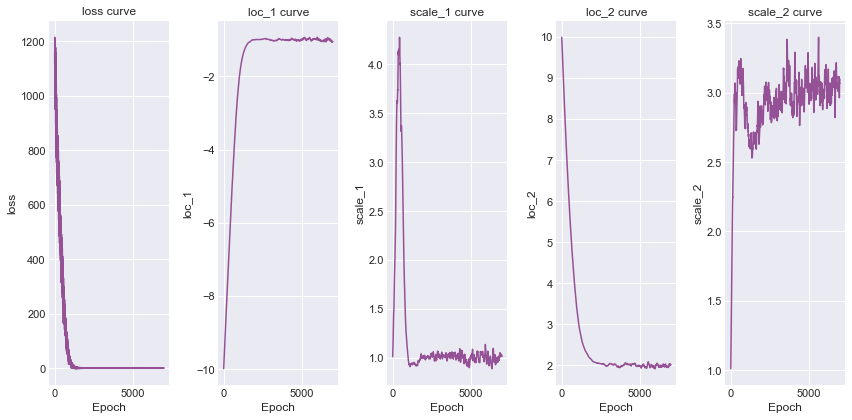

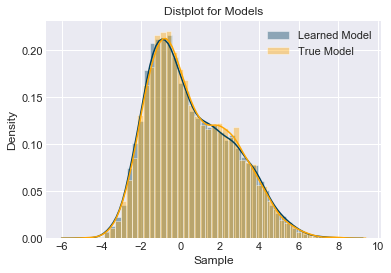

In [462]:
p_model = Mixture([Normal([-1.0], [[1.0]]), Normal([2.0], [[3.0]])], [0.5, 0.5])
q_model = Mixture([Normal([-10.0], [[1.0]]), Normal([10.0], [[1.0]])], [0.5, 0.5])

plot_models(p_model, q_model)
stats = train(p_model, q_model, reverse_kl, epochs=7000)
plot_stats(stats)
plot_models(p_model, q_model)

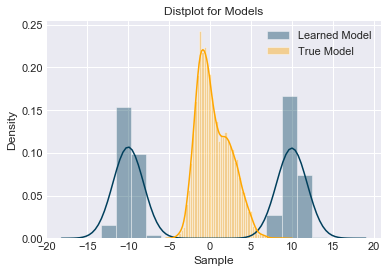

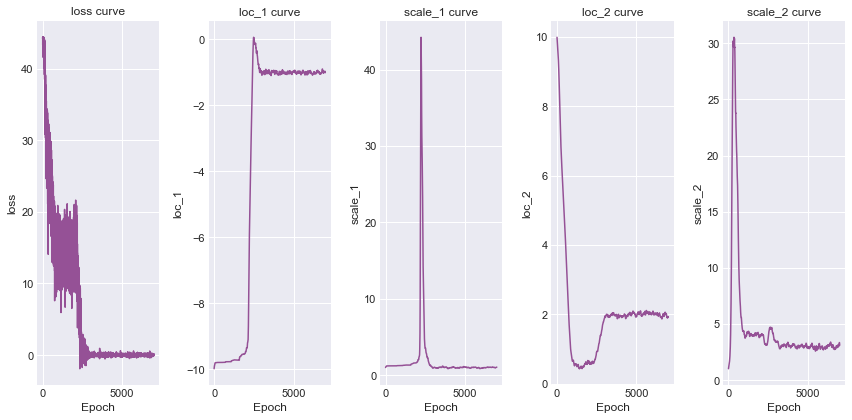

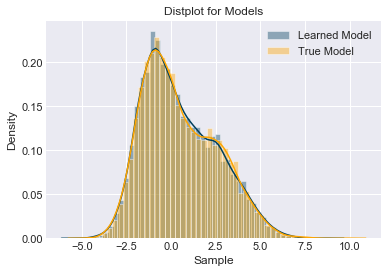

In [463]:
p_model = Mixture([Normal([-1.0], [[1.0]]), Normal([2.0], [[3.0]])], [0.5, 0.5])
q_model = Mixture([Normal([-10.0], [[1.0]]), Normal([10.0], [[1.0]])], [0.5, 0.5])

plot_models(p_model, q_model)
stats = train(p_model, q_model, js_divergence, epochs=7000)
plot_stats(stats)
plot_models(p_model, q_model)